# **Линейная/Логистическая Регрессия**

## **<span style='color:#F1A424'>Добавление Регуляризации</span>**

Реализуем регуляризацию в линейную модель

- Для борьбы с переобучением добавим регуляризацию
- Сначала обернём линейную регрессию в классовое представление
- **Потом добавим вариант с регуляризации** (В этом ноутбуке)

### **Общая Функция Градиентного Спуска**

- Добавим то что мы добавили ранее в классовую форму
- `regOptimiser` добавляем общие функции которые используются как и в регрессии так и в классификации с градиентным спуском

Пройдемся по компонентам общего класса:
- <code>gradient_step</code> - функция шага градиентного спуска
- <code>optimize</code> - функция для обновления гипертараметра theta

In [4]:
import numpy as np

class regOpt():

    # initialisation

    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters

    # gradient step

    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad

    # gradient function

    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    # optimisation process of theta

    def optimize(self, X, y, start_theta, n_iters):

        # theta_0
        theta = start_theta.copy()

        for _ in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)

        return theta

    # Тренируем модель
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)

    # Делаем предсказание
    def predict(self, X):
        raise NotImplementedError()

### **Дочерний Класс для LinReg**

Создадим еще один дочерний класс, в этот раз для <code>LinReg</code>, внесем корректировку в <code>grad_func</code>:

После добавления регуляризации функция ошибки линейной регрессии будет выглядеть следующим образом:


$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} + \frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2}$$


А ее градиент по параметру $\theta$:


$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j} = \frac{1}{n}X^T(X\theta - y) + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j}$$

In [6]:
# linReg будет иметь доступ к функции из regOptimiser
class LinReg(regOpt):

    # для линейной регресии у нас функция потерь
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1.0 / n * X.T.dot(X.dot(theta) - y)
        return grad

    # для линейной регрессии предсказание X.theta
    def predict(self, X):
        if(self.theta is None):
            raise Exception('You should train the model first')

        y_pred = X.dot(self.theta)

        return y_pred


In [7]:
# Линейная регрессия с регуляризации
class rLinReg(LinReg):

    # initialise parent class
    def __init__(self, alpha, lambd, n_iters):
        super(rLinReg, self).__init__(alpha, n_iters)
        self._lambd = lambd

    # method overwriting
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1.0 / n * X.T.dot(X.dot(theta) - y) # стандартный градиент функции потерь
        grad_term = self._lambd * np.mean(theta)   # дополнительный термин
        return grad + grad_term

Проверим модель на примере предсказания стоимости жилья в Бостоне (задача регрессии)

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Функци для определения RMSE
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

# Функуия для предобработки & подготовки X,y
def prepare_boston_data():
    df = pd.read_csv('data.csv')
    y = df['medv']
    X = df.drop(['medv'],axis=1)

    # Нормализовать даннные с помощью стандартной нормализации
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:,None], X])
    return X, y

# Иницилизируем линейной регрессии с alpha = 0.01, 500 итерации
linreg = rLinReg(alpha=0.01, lambd=0.05, n_iters=500)

# Разбиваем выборку на тренировочную и валидационную выборку
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# Тренируем модель на train выборке
linreg.fit(X_train, y_train)

# Предсказываем и оцениваем качество модели на валидационной выборке
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

# без регуляризации : MSE = 26.19

MSE = 21.75, RMSE = 4.66


### **Дочерний Класс для LogReg**

Функция ошибки для логистической регрессии в случае бинарной классификации с регуляризатором записывается следующим образом:


$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i)))+\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$


- $x_i$ — вектор признаков
- $i$-го примера из обучающей выборки
- $y_i$ — истинный класс для соответствующего примера (0 или 1),- $n$ — число примеров в обучающей выборке
- $m$ — количество нефиктивных признаков
- $\lambda$ — параметр регуляризации
- $h_{\theta}(x)$ — sigmoid функция, равная:


$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$


- $\theta$ — вектор параметров логистической регрессии,
- $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:


$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}+\frac{\lambda}{m}\sum_{j}^{m}{\theta_j}$$

In [11]:
from sklearn.metrics import f1_score, accuracy_score

class LogReg(regOpt):

    def sigmoid(self, X, theta):
        return 1.0 / (1.0 + np.exp(-X.dot(theta)))

    # отличие только в self.sigmoid(X, theta)
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1.0 / n * X.T.dot(self.sigmoid(X, theta) - y)

        return grad

    # Вероятность принадлежности класса (0/1)
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)

    # Предсказание с порогом 0.5
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')

        y_pred = self.predict_proba(X) > 0.5

        return y_pred

In [12]:
# нам нужно изменить только градиент функции огибки

class rLogReg(LogReg):

    def __init__(self, alpha, lambd, n_iters):
        super(rLogReg, self).__init__(alpha, n_iters)
        self._lambd = lambd

    # добавляем дополнительный термин
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1.0 / n * X.T.dot(self.sigmoid(X, theta) - y)
        grad_term = self._lambd * np.mean(theta)
        return grad + grad_term

In [16]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

def prepare_adult_data():

    adult = pd.read_csv('adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                               'education-num', 'marital-status', 'occupation',
                               'relationship', 'race', 'sex', 'capital-gain',
                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])

    # Избавиться от лишних признаков
    adult.drop(['native-country'], axis=1, inplace=True)
    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status',
                                           'occupation', 'relationship', 'race', 'sex'])

    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

    # Разбить таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:,None], X])

    return X, y

Проверим модель на примере предсказания клссификации доходов (задача бирарной классификации)

In [18]:
logreg = rLogReg(alpha=1.0, lambd=1.0, n_iters=300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)
print_logisitc_metrics(y_valid, y_pred)

acc = 0.86 F1-score = 0.67


In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=10)
    plt.xlabel('False positive rate (FPR)', fontsize=10)
    plt.ylabel('True positive rate (TPR)', fontsize=10)
    plt.legend(fontsize=10)

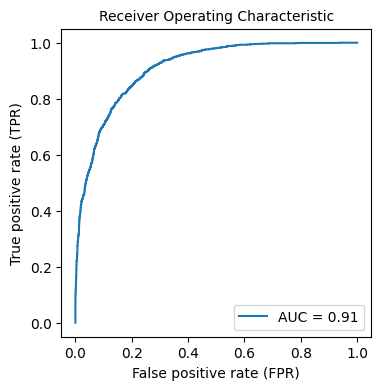

In [20]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)